# Precip and temperature probe

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Input / Target Data

In [16]:
# out_dir

In [4]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable


if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

In [5]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
ds.data_vars

Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

### transform dataa

In [6]:
# log_normalise
eps = 1e-10
log_p = np.log(ds["precipitation"] + eps)
p_mean_ = log_p.mean(dim="time")
p_std_ = log_p.std(dim="time")
lognorm_p = (log_p - p_mean_) / p_std_

In [7]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# quantile-transform
qt = QuantileTransformer()
qt_p = qt.fit_transform(ds["precipitation"] + eps)

In [8]:
# box-cox 
pt = PowerTransformer(method='box-cox', standardize=True)
boxcox_p = pt.fit_transform(ds["precipitation"] + eps)

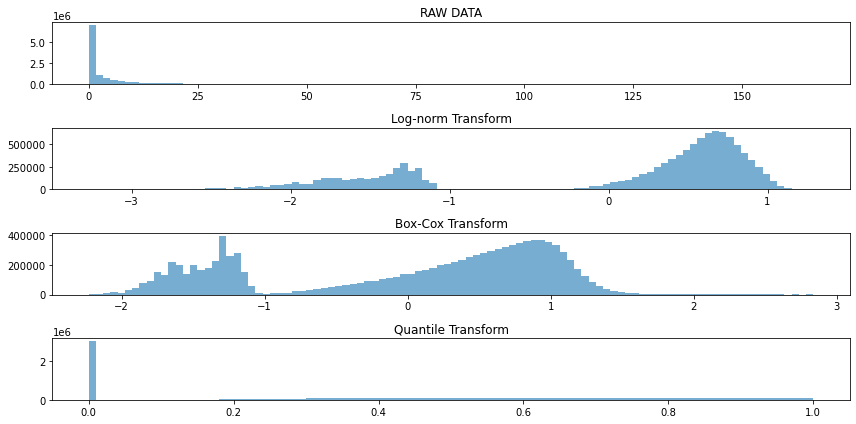

In [9]:
f, axs = plt.subplots(4, 1, figsize=(12, 6))

ax = axs[0]
ax.hist((ds["precipitation"].values).flatten(), alpha=0.6, bins=100);
ax.set_title("RAW DATA")

ax = axs[1]
ax.hist((lognorm_p.values).flatten(), alpha=0.6, bins=100);
ax.set_title("Log-norm Transform")

ax = axs[2]
ax.hist((boxcox_p).flatten(), alpha=0.6, bins=100);
ax.set_title("Box-Cox Transform")

ax = axs[3]
ax.hist((qt_p).flatten(), alpha=0.6, bins=100);
ax.set_title("Quantile Transform")

plt.tight_layout();

# Train the probes

In [10]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from collections import defaultdict

In [11]:
target_ds = lognorm_p.to_dataset()
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]
target_var = "precipitation"

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


# all_train_test = defaultdict(dict)
print(f"** STARTING {target_var} **")
train_dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Train Samples",
)

train = get_time_basin_aligned_dictionary(train_dataset)

test_dataset = TimeSeriesDataset(
    input_data=test_input_data,
    target_data=test_target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Test Samples",
)

test = get_time_basin_aligned_dictionary(test_dataset)

# all_train_test[target_var]["train"] = train
# all_train_test[target_var]["test"] = test

** STARTING precipitation **


Extracting Data: 100%|██████████| 8347/8347 [01:02<00:00, 134.21it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2149/2149 [00:15<00:00, 138.03it/s]

Merging and reshaping arrays


In [12]:
print(f"** {target_var} **")
model, preds, errors = fit_and_predict(train, test, random_seed=100)

** precipitation **
-- Epoch 1
Norm: 0.42, NNZs: 35, Bias: 0.448896, T: 1923107, Avg. loss: 0.052002
Total training time: 1.58 seconds.
-- Epoch 2
Norm: 0.41, NNZs: 34, Bias: 0.447650, T: 3846214, Avg. loss: 0.051971
Total training time: 3.32 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 35, Bias: 0.447529, T: 5769321, Avg. loss: 0.051970
Total training time: 5.01 seconds.
-- Epoch 4
Norm: 0.41, NNZs: 36, Bias: 0.447557, T: 7692428, Avg. loss: 0.051968
Total training time: 6.70 seconds.
Convergence after 4 epochs took 6.84 seconds


Calculating Errors: 100%|██████████| 669/669 [00:07<00:00, 85.88it/s, 107001]


# Explore Results

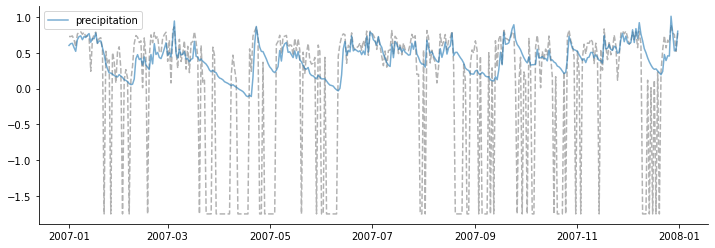

In [13]:
p = preds
time = "2007"

N = 1
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    data = preds.sel(station_id=px, time=time)

    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
    ax.plot(data.time, data.sim, ls="-", alpha=0.6, label=f"{target_var}")
    ax.legend()
    sns.despine()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

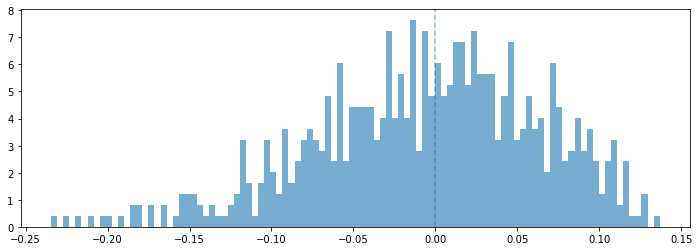

In [14]:
f, ax = plt.subplots(figsize=(12, 4))

nse = errors["NSE"]
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), ls="--", alpha=0.5)    
plt.set_title("")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

In [ ]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

f, ax = plt.subplots(figsize=(12, 2))
w, b = get_model_weights(model)
plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
ax.set_title(f"Target: {target_var}")
plt.tight_layout()

# Temperature

In [ ]:
temp_mean_ = ds["temperature"].mean(dim="time")
temp_std_ = ds["temperature"].std(dim="time")

norm_temp = (ds["temperature"] - temp_mean_) / temp_std_

In [ ]:
f, axs = plt.subplots(2, 1, figsize=(12, 3))

ax = axs[0]
ax.hist((ds["precipitation"].values).flatten(), alpha=0.6, bins=100);
ax.set_title("RAW DATA")

ax = axs[1]
ax.hist((norm_temp.values).flatten(), alpha=0.6, bins=100);
ax.set_title("Normal Transform")

plt.tight_layout()

In [ ]:
target_ds = norm_temp.to_dataset()
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]
target_var = "temperature"

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


# all_train_test = defaultdict(dict)
print(f"** STARTING {target_var} **")
temp_train_dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Train Samples",
)

temp_train = get_time_basin_aligned_dictionary(temp_train_dataset)

temp_test_dataset = TimeSeriesDataset(
    input_data=test_input_data,
    target_data=test_target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Test Samples",
)

temp_test = get_time_basin_aligned_dictionary(temp_test_dataset)

# all_train_test[target_var]["train"] = train
# all_train_test[target_var]["test"] = test

In [ ]:
print(f"** {target_var} **")
temp_model, temp_preds, temp_errors = fit_and_predict(temp_train, temp_test, random_seed=100)

# Explore Results

In [ ]:
time = "2007"

N = 1
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    data = temp_preds.sel(station_id=px, time=time)

    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
    ax.plot(data.time, data.sim, ls="-", alpha=0.6, label=f"{target_var}")
    ax.legend()
    sns.despine()

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

nse = temp_errors["NSE"]
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), ls="--", alpha=0.5)    
ax.set_title("NSE")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

In [ ]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

f, ax = plt.subplots(figsize=(12, 2))
temp_w, temp_b = get_model_weights(temp_model)
plot_weights(np.abs(temp_w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
ax.set_title(f"Target: {target_var}")
plt.tight_layout()

In [ ]:
temp_analysis_ds = create_analysis_dataset(temp_test)

max_idx = np.argmax(np.abs(temp_w))
n = 2
largest_n = np.abs(temp_w).argsort()[-n:][::-1]
feature = f"dim{max_idx}"

features = [f"dim{idx}" for idx in largest_n]
assert feature in temp_analysis_ds.data_vars

In [ ]:
time = "2007"
px = 53013
# px = np.random.choice(analysis_ds.station_id.values)

f, ax = plt.subplots(figsize=(12, 4))
data = temp_analysis_ds.sel(station_id=px, time=time).to_dataframe()
ax.plot(data.index, data["y"], label="Target", color="k", ls="--", alpha=0.6)
ax.legend(loc="upper right")

ax = ax.twinx()
for ix, feature in enumerate(features):  # features  ["dim20"]
    ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
    ax.legend(loc="upper left")

sns.despine()